# **Эмпирическое исследование взаимосвязи между показателем брака на производстве и различными параметрами использованной для производства технологии: новый пайплайн 2025**

### Для начала верхнеуровнево рассмотрим пайплайн 2024 года

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
from scipy.stats import norm
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

def remove_highly_correlated_features(X, threshold):
    # Вычисляем корреляционную матрицу
    corr_matrix = X.corr().abs()
    # Находим коррелированные пары признаков (в треугольной матрице, чтобы не учитывать симметрию)
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Находим признаки с корреляцией выше заданного порога
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    # Удаляем сильно коррелированные признаки
    X_reduced = X.drop(columns=to_drop)
    return X_reduced, to_drop

def plot_corr_matrix(data, fname):
    corr_mat = data.corr()
    mask = corr_mat.abs() < 0.5

    max_length = 80  # Максимальная длина названий
    shortened_columns = [col[:max_length] + '...' if len(col) > max_length else col for col in corr_mat.columns]
    shortened_index = [col[:max_length] + '...' if len(col) > max_length else col for col in corr_mat.index]

    sns.clustermap(data.corr(), mask=mask, 
                linewidths=0.5, fmt=".2f", annot=True, annot_kws={"size": 8},
                linecolor="gray", cmap="coolwarm", 
                xticklabels=shortened_columns, yticklabels=shortened_index,
                figsize=(20, 20))
    plt.savefig(f"{fname}.png", dpi=300)

def calc_margin_effects_manually(xtrain, ytrain) -> list:
    model = LogisticRegression(max_iter=1000)
    model.fit(xtrain, ytrain)
    probs = model.predict_proba(xtrain)[:, 1]

    coefficients = model.coef_[0]
    marginal_effects = (probs * (1 - probs))[:, np.newaxis] * coefficients
    average_marginal_effects = np.mean(marginal_effects, axis=0)

    for feature, effect in zip(xtrain.columns, average_marginal_effects):
        print(f"Предельный эффект для {feature}:\t{effect}")
    return model, average_marginal_effects

def results_report(model, xtest, ytest, me, fname):
    coefficients = model.coef_[0]
    n_iterations = 300
    n_size = len(xtest)
    bootstrapped_coefficients = np.zeros((n_iterations, len(coefficients)))

    for i in range(n_iterations):
        # Генерация бутстрэп-выборки
        X_bs, y_bs = resample(xtest, ytest, n_samples=n_size)
        model_bs = LogisticRegression()
        model_bs.fit(X_bs, y_bs)
        bootstrapped_coefficients[i, :] = model_bs.coef_[0]

    # Оценка стандартных ошибок
    standard_errors = np.std(bootstrapped_coefficients, axis=0)

    # Расчет z-значений и p-значений
    z_values = coefficients / standard_errors
    p_values = [2 * (1 - norm.cdf(np.abs(z))) for z in z_values]

    print(f"Свободный коэффициент: {model.intercept_[0]}")
    results = pd.DataFrame({
        'column': xtest.columns,
        'coeff': coefficients,
        'margin effects': me,
        'stderr': standard_errors,
        'z-value': z_values,
        'p-value': p_values
    })
    results.to_csv(f"{fname}.csv")
    print(results)

weight_balanced = False # разрешение балансировки весов в сторону дефектов
df = pd.read_excel("decrypted_TECH_SAMPLE.xlsx")
df_initial = pd.read_excel("decrypted_TECH_SAMPLE.xlsx")
# wm = "РД" # метод сварки
class_weight_data = {0: 5, 1: 2} # доли смещения весов weight_balanced=True

#### Фильтрация строк с известными материалами, удаление нерелевантных колонок и one-hot кодирование категориальных признаков

In [5]:
# df = df[(df["welding_materials"] != "неизвестно") & (df["welding_method"] == wm)]
df = df[(df["welding_materials"] != "неизвестно")]
# df = df.drop(columns=["date", "name", "Unnamed: 0", "welding_method", "welding_materials"])
df = df.drop(columns=["date", "name", "Unnamed: 0"])
categorical_features = ["diameter", "steel_grade", "welding_materials", "welding_method"]
df_one_hot = pd.get_dummies(df, columns=categorical_features, dtype="int")

independent = df_one_hot.drop(columns=["defect"])
dependent = df_one_hot["defect"]

#### Кореляционная матрица

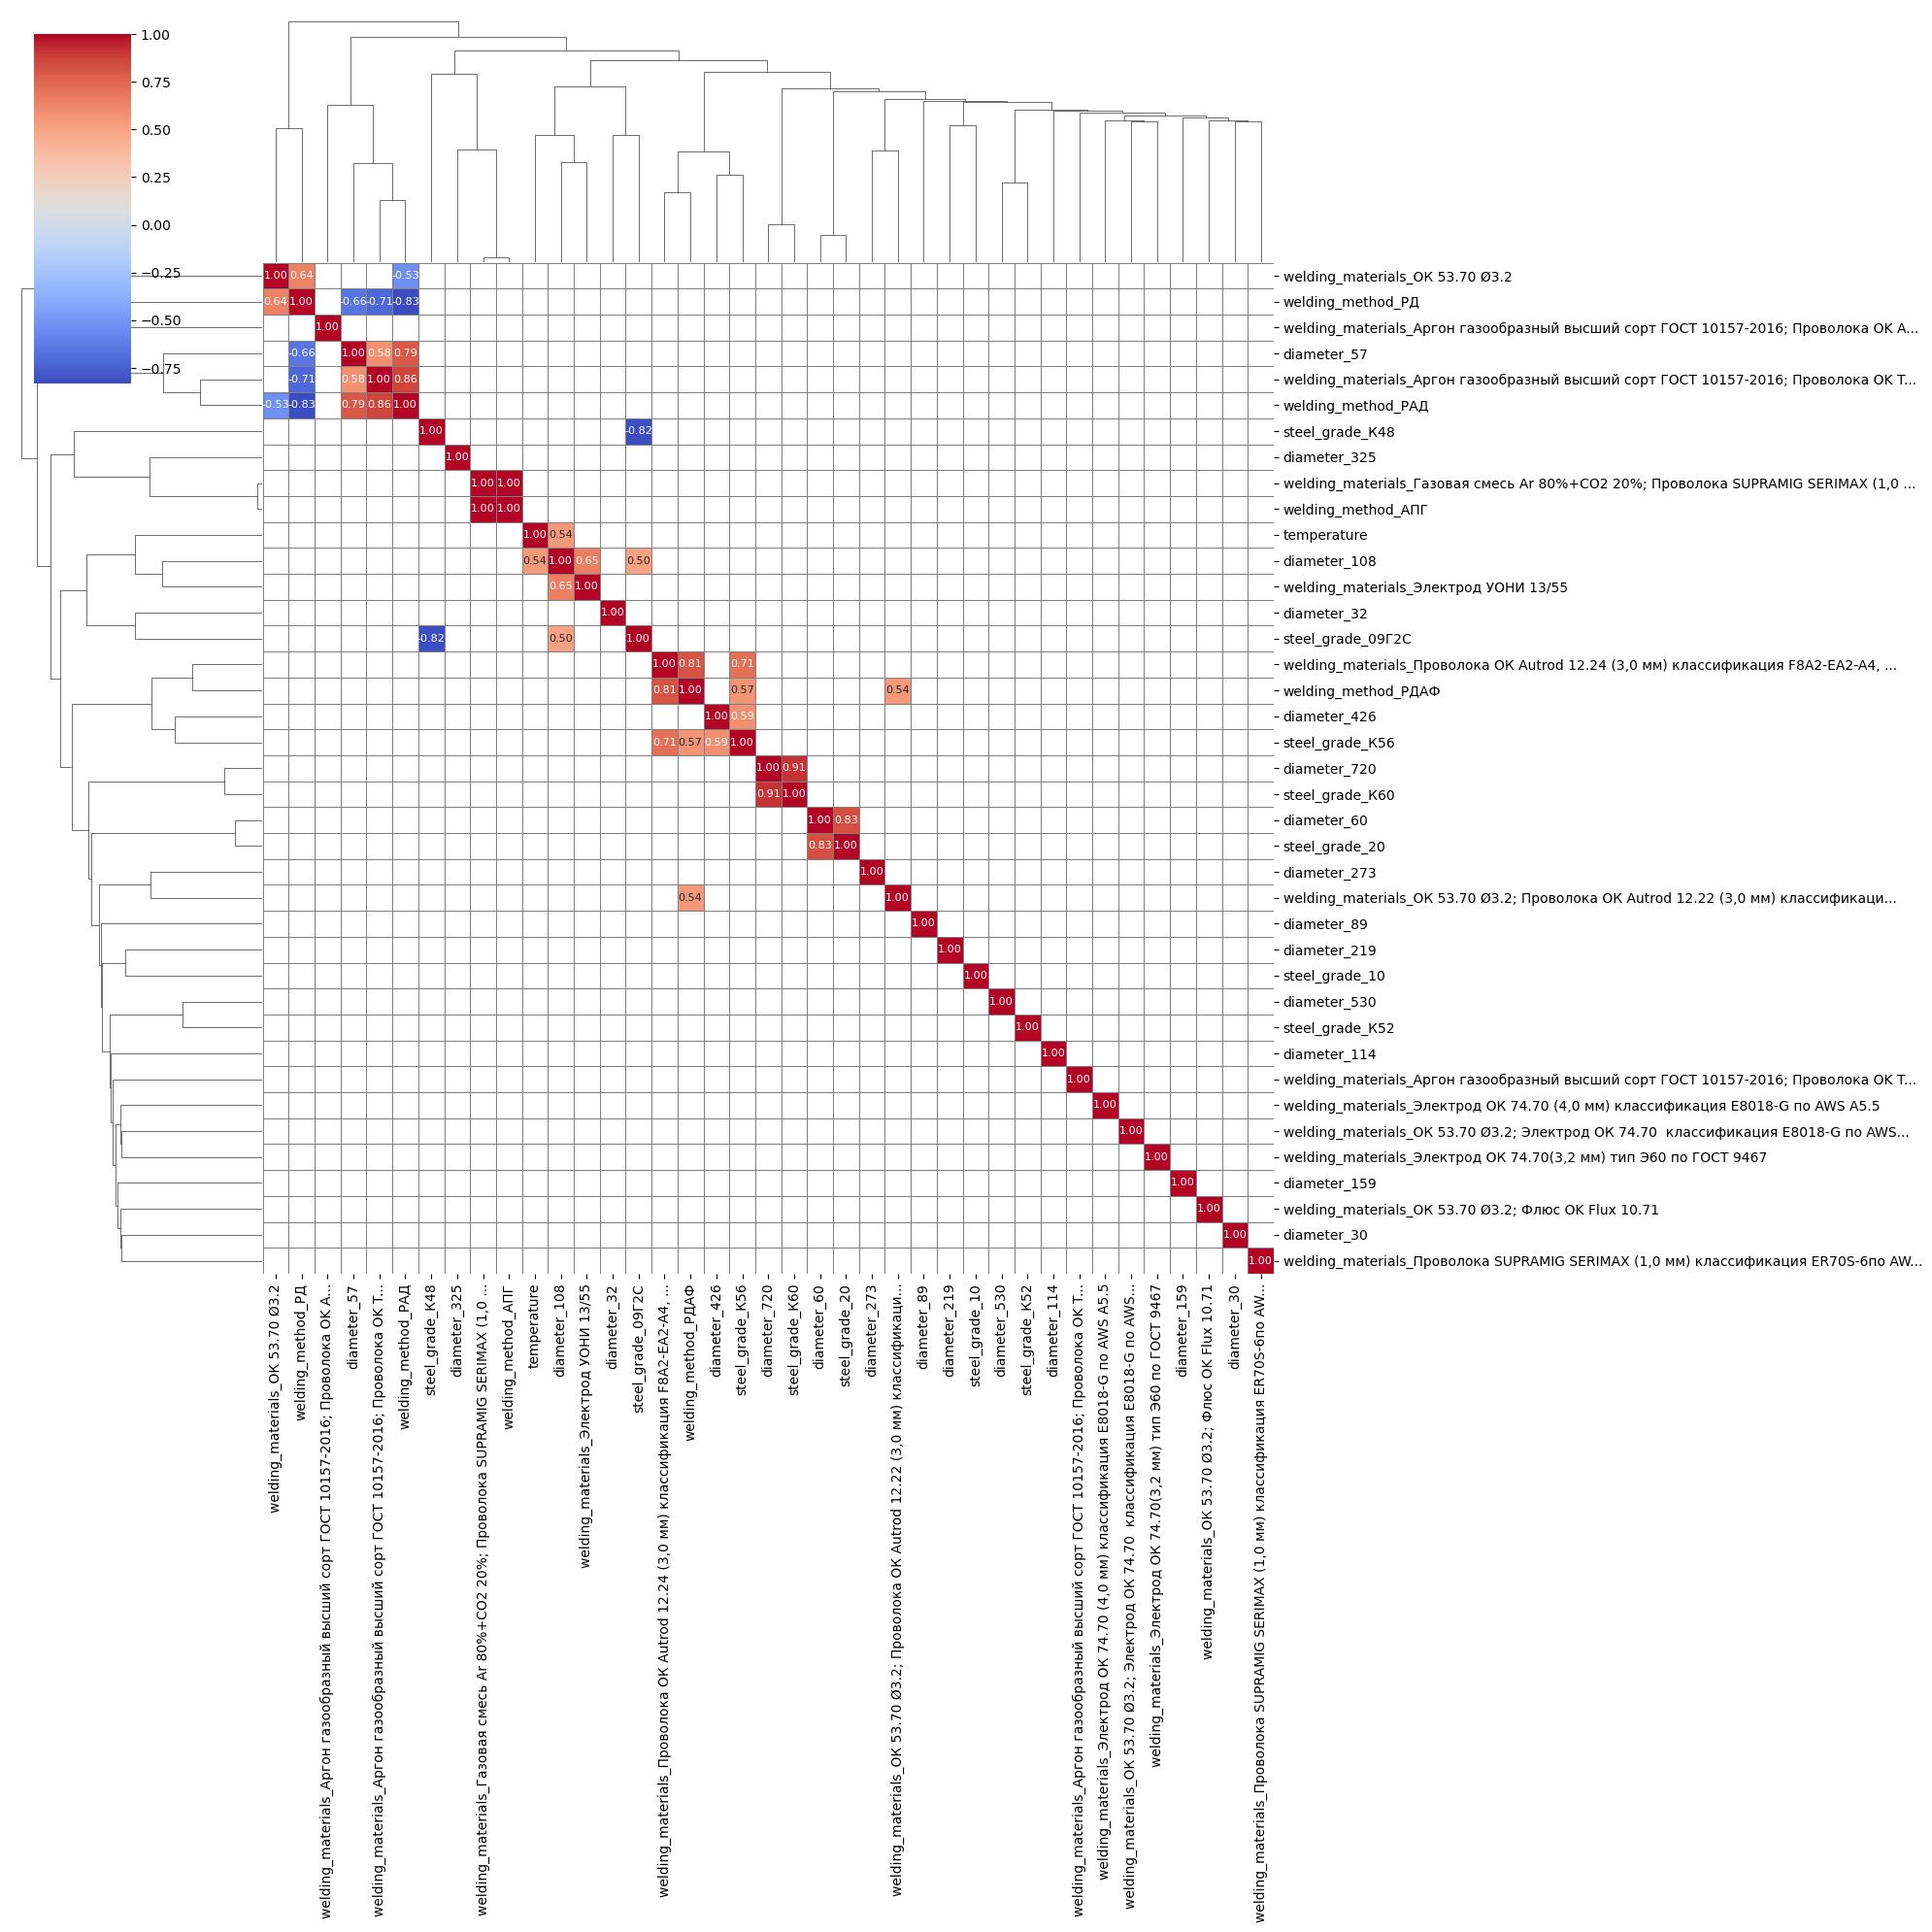

In [7]:
plot_corr_matrix(independent, "corr_mat_1")

### Оценка ранга матрицы

In [9]:
rank = np.linalg.matrix_rank(independent)
print(f"Текущий ранг: {rank}, кол-во параметров: {independent.shape[1]}")
print(f"Если ранг меньше, чем число признаков, значит, есть линейная зависимость, и нужно удалить лишние признаки.")
constant_features = [col for col in independent.columns if independent[col].nunique() <= 1]
print("Константные признаки:", constant_features)

Текущий ранг: 32, кол-во параметров: 39
Если ранг меньше, чем число признаков, значит, есть линейная зависимость, и нужно удалить лишние признаки.
Константные признаки: []


#### Обычный сплит на train и test

In [11]:
independent = independent.assign(intercept=1)
X_train, X_test, y_train, y_test = train_test_split(independent, dependent, test_size=0.3, random_state=12)

## Верхнеуровнево концепт

Ранее командой были рассмотрены два пайплайна: 
1) **Подход 1**: работа с датасетом "as is", т. е. построение модели на всех признаках без явного Feature Selection;
2) **Подход 2**: относительно упрощенный Feature Selection - исключение из модели всех признаков с корреляцией с порогом threshold > 0.5

#### Примерно так выглядел подход 2:

In [394]:
# # df = df[(df["welding_materials"] != "неизвестно") & (df["welding_method"] == wm)]
# # df = df[(df["welding_materials"] != "неизвестно")]
# # df = df.drop(columns=["date", "name", "Unnamed: 0", "welding_method", "welding_materials"])"diameter", 
# #df = df.drop(columns=["date", "name", "Unnamed: 0"])
# categorical_features = ["steel_grade", "welding_materials", "welding_method"]
# df_one_hot = pd.get_dummies(df, columns=categorical_features, dtype="int")

# independent = df_one_hot.drop(columns=["defect"])

# independent, dropped_features = remove_highly_correlated_features(independent, threshold=0.5)
# print(f"Удаленные признаки {len(dropped_features)}:", dropped_features)

# dependent = df_one_hot["defect"]

# rank = np.linalg.matrix_rank(independent)
# print(f"\nТекущий ранг: {rank}, кол-во параметров: {independent.shape[1]}")
# print(f"Если ранг меньше, чем число признаков, значит, есть линейная зависимость, и нужно удалить лишние признаки.")
# constant_features = [col for col in independent.columns if independent[col].nunique() <= 1]
# print("Константные признаки:", constant_features)

## Новый пайплайн 2025

Предлагаю рассмотреть несколько другой пайплайн решения задачи, взяв за основу базовые идеи из работы 2024 года, но в этот раз уже проработав решение задачи несколько с другой стороны. Работаю аналогично с логистической регрессией, так как задача - получить как можно больше интерпертируемых признаков (т. е. признаков с некоторыми весами, полученными с помощью MLE).
Напомню, что базовая обработка была проведена в Excel (включая обработку большинства пропусков).

### Библиотеки

In [398]:
# Базовые библиотеки
import numpy as np
import pandas as pd
import time

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Статистика
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.api import add_constant, OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.sandwich_covariance import cov_hc1

# Эконометрические модели
from linearmodels.iv import IV2SLS

# Машинное обучение
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, mean_squared_error, r2_score, recall_score, make_scorer
)

# CatBoost
from catboost import CatBoostClassifier
import category_encoders as ce

# Hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Прогресс-бар
from tqdm import tqdm

# Настройки pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

### Функции

In [26]:
def plot_corr_matrix(data, fname):
    corr_mat = data.corr()
    mask = corr_mat.abs() < 0.5

    max_length = 80 
    shortened_columns = [col[:max_length] + '...' if len(col) > max_length else col for col in corr_mat.columns]
    shortened_index = [col[:max_length] + '...' if len(col) > max_length else col for col in corr_mat.index]

    sns.set(style="white")
    cluster_plot = sns.clustermap(
        corr_mat, 
        mask=mask, 
        linewidths=0.5, 
        fmt=".2f", 
        annot=True, 
        annot_kws={"size": 8},
        linecolor="gray", 
        cmap="magma_r",
        xticklabels=shortened_columns, 
        yticklabels=shortened_index,
        figsize=(20, 20)
    )

    cluster_plot.savefig(f"{fname}.png", dpi=300)
    plt.show()

### Feature Selection

In [28]:
df = df_initial
df.head()

,Unnamed: 0,date,name,defect,temperature,diameter,steel_grade,welding_method,welding_materials
0,0,2024-06-25,Коноплёв Алексей Александрович,1,27,159,К48,РД,неизвестно
1,1,2024-06-25,Коноплёв Алексей Александрович,1,27,159,К48,РД,неизвестно
2,2,2024-06-25,Фатыхов Ильшат Рифович,1,27,114,К48,РД,ОК 53.70 Ø3.2
3,3,2024-06-25,Фатыхов Ильшат Рифович,1,27,114,К48,РД,ОК 53.70 Ø3.2
4,4,2024-06-25,Баимов Айдар Тимерханович,1,27,108,К48,РД,Электрод УОНИ 13/55


In [29]:
df = df.drop(columns=["date", "name", "Unnamed: 0"])

In [30]:
df.head()

,defect,temperature,diameter,steel_grade,welding_method,welding_materials
0,1,27,159,К48,РД,неизвестно
1,1,27,159,К48,РД,неизвестно
2,1,27,114,К48,РД,ОК 53.70 Ø3.2
3,1,27,114,К48,РД,ОК 53.70 Ø3.2
4,1,27,108,К48,РД,Электрод УОНИ 13/55


In [31]:
for col in df.columns:
    column = df[f'{col}']
    column_uniq = column.nunique()
    print(f"Количество уникальных значений для колонки {col}:\n{column_uniq}")

Количество уникальных значений для колонки defect:
2
Количество уникальных значений для колонки temperature:
61
Количество уникальных значений для колонки diameter:
24
Количество уникальных значений для колонки steel_grade:
7
Количество уникальных значений для колонки welding_method:
5
Количество уникальных значений для колонки welding_materials:
14


### One-Hot кодирование (так как хотим оценить каждую категорию в рамках переменной как дамми)

In [33]:
categorical_features = ["diameter", "steel_grade", "welding_materials", "welding_method"]
df_one_hot = pd.get_dummies(df, columns=categorical_features, dtype="int")

In [34]:
df_one_hot

,defect,temperature,diameter_15,diameter_18,diameter_20,diameter_22,diameter_25,diameter_30,diameter_32,diameter_40,...,"welding_materials_Проволока ОК Autrod 12.24 (3,0 мм) классификация F8A2-EA2-A4, F7P0-EA2-A4по AWS A5.23; Флюс OK Flux 10.71; Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467","welding_materials_Электрод ОК 74.70 (4,0 мм) классификация E8018-G по AWS A5.5","welding_materials_Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467",welding_materials_Электрод УОНИ 13/55,welding_materials_неизвестно,welding_method_ААД,welding_method_АПГ,welding_method_РАД,welding_method_РД,welding_method_РДАФ
0,1,27,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,1,27,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,27,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42945,1,11,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
42946,1,11,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
42947,1,11,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
42948,1,11,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [35]:
independent = df_one_hot.drop(columns=["defect"])
dependent = df_one_hot["defect"]

### Давайте подумаем над проблемой мультиколлинеарности

**Предпосылка ГМ-3. Вариативность регрессоров**


**Множественная регрессия:** 

Отсутствие полной коллинеарности в регрессорах. Выборка значений случайных величин $x_1, \dots, x_k$, а именно $\{x_{i1},\dots,x_{ik}, i =1,\dots,n\}$, имеет вариативность, а также среди регрессоров отсутствует строгая линейная зависимость.

#### Корреляционная матрица

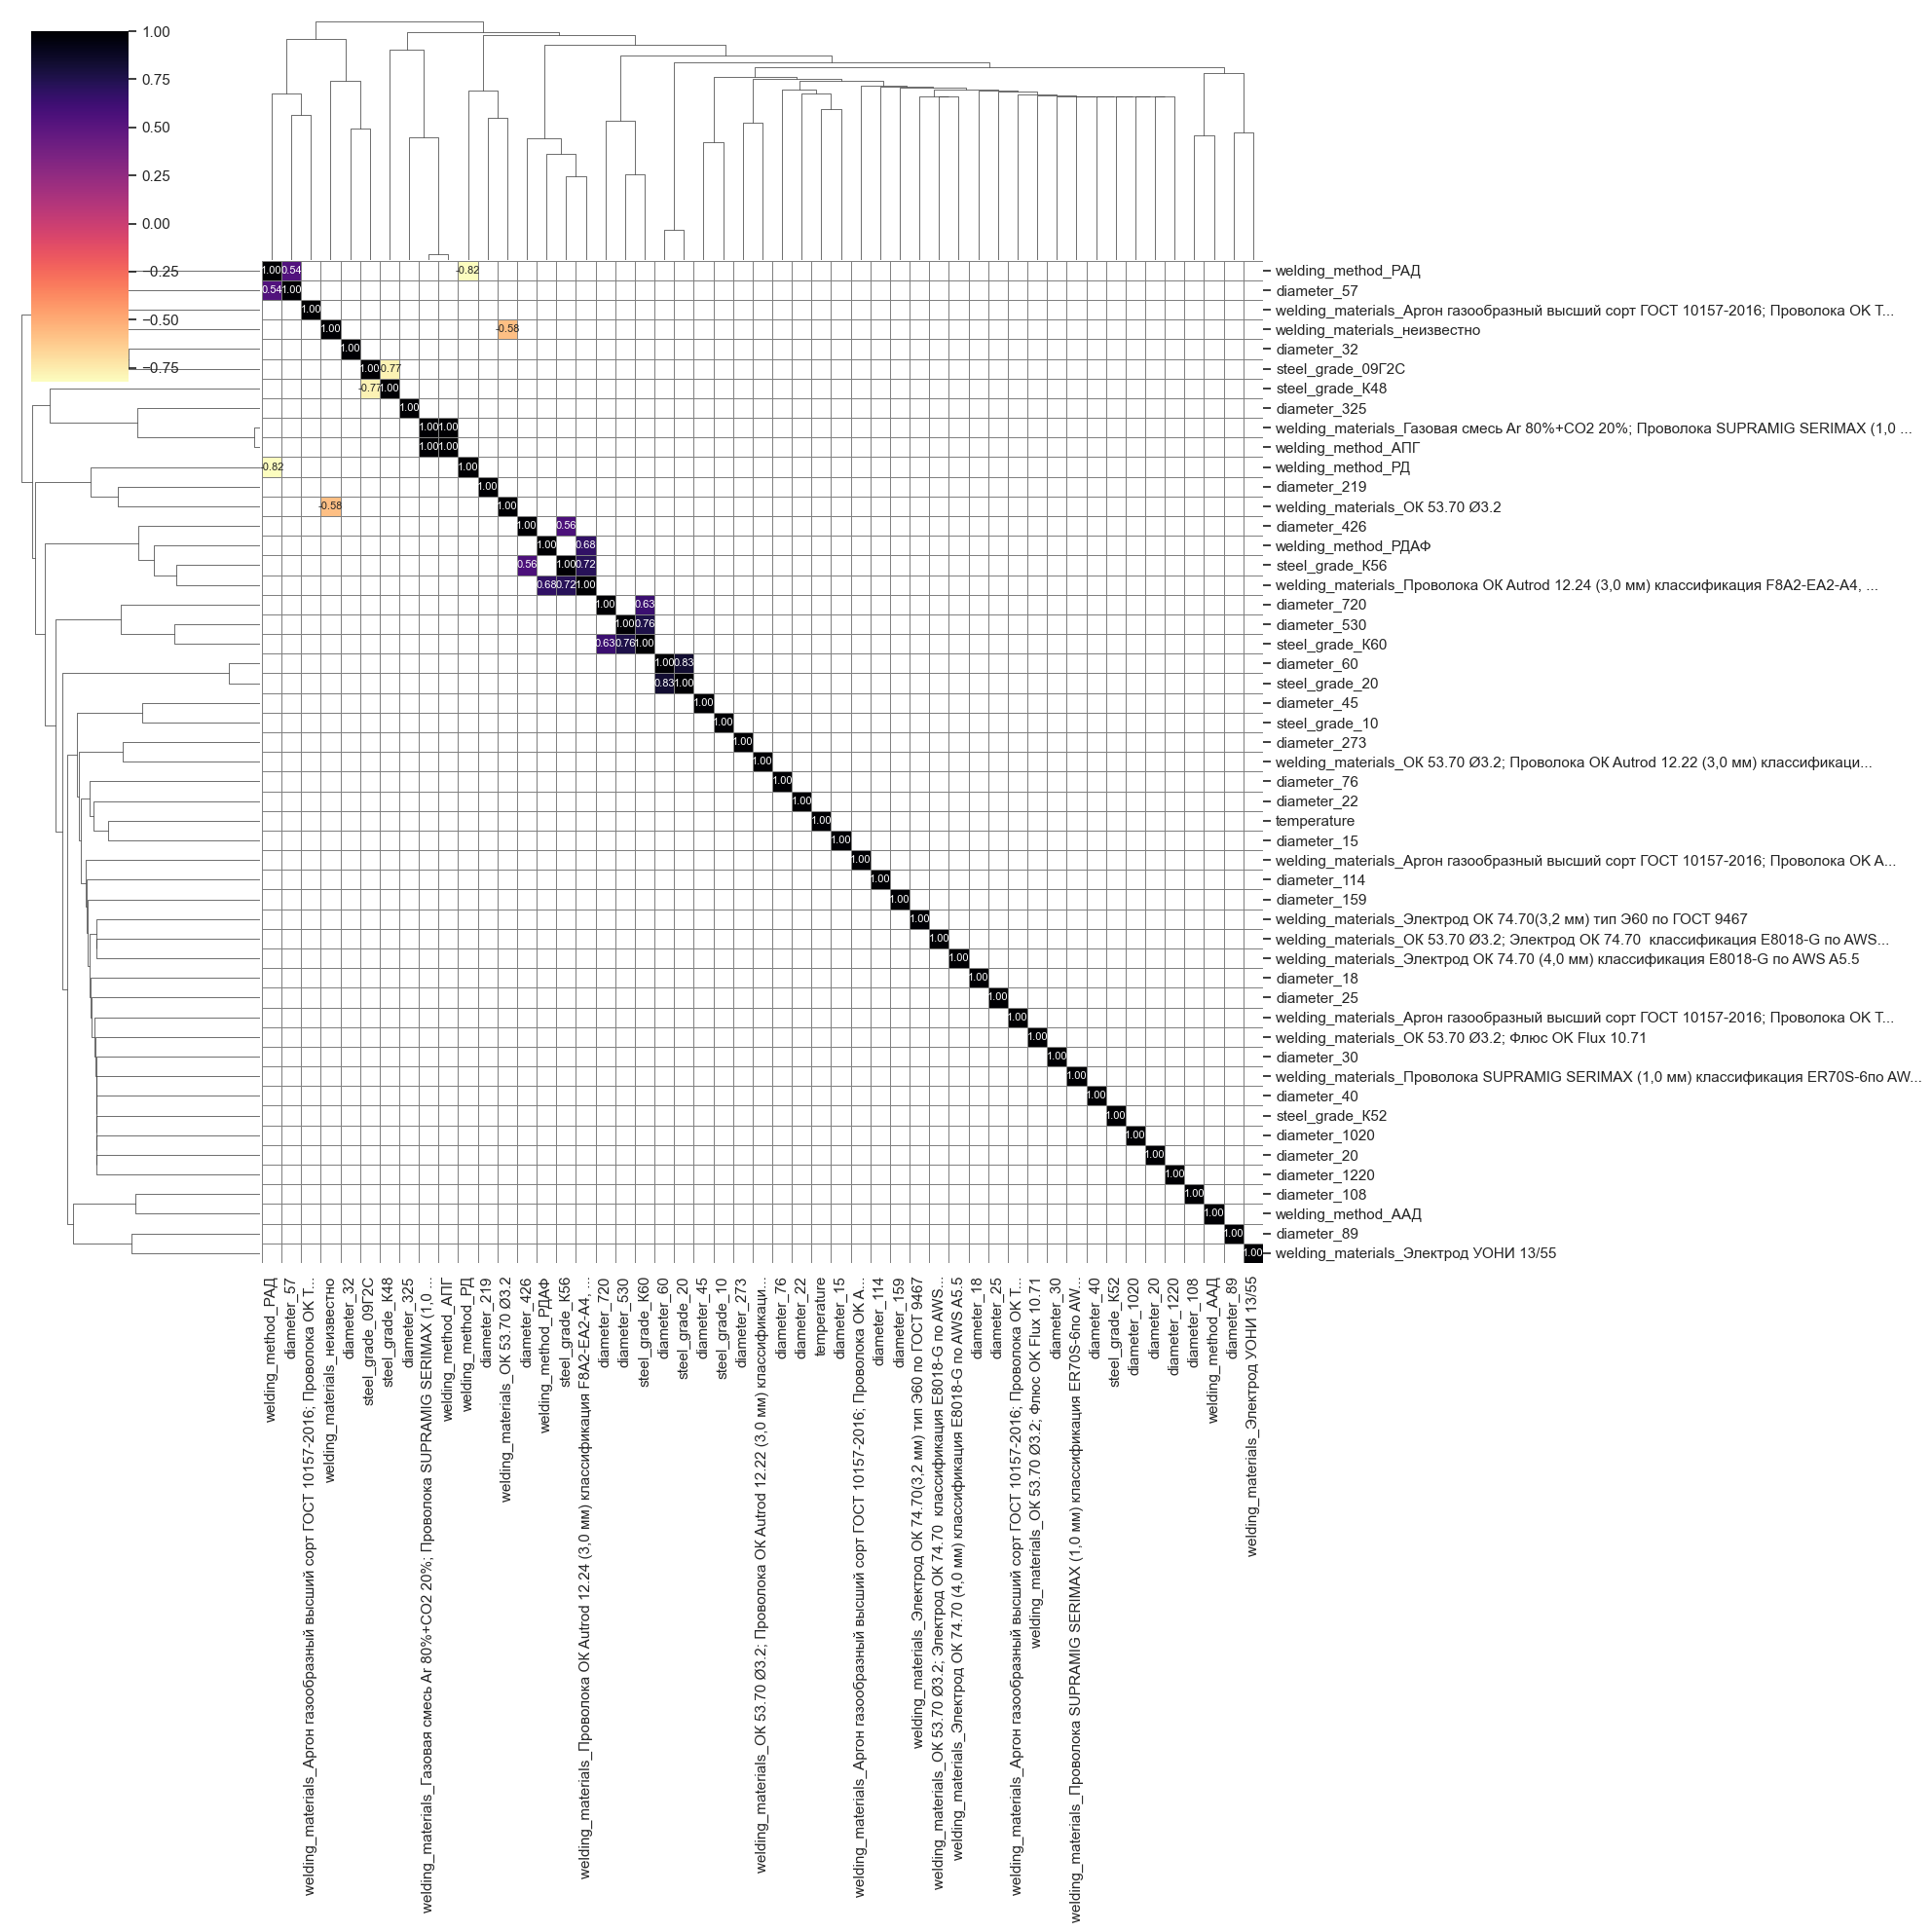

In [37]:
plot_corr_matrix(independent, "corr_mat_1")

#### Бизнес-логика: мы не можем просто так избавиться от признаков с высоким показателем корреляции. Нужно решение, которое обеспечит относительно релевантные оценки регрессии, но при этом сохранит как можно больше признаков в модели.

Однако, есть подходы для численной оценки уровня мультиколлинеарности. Некоторые из них:

- **Variance Inflation Factor (VIF)** — наиболее часто используемая метрика. Это частная мера зависимости дисперсии оценки коэффициента $\beta_j$ от корреляции рассматриваемого регрессора со всеми прочими регрессорами:
$$\large
VIF_j = \frac{1}{1 - R^2_j}
$$
Откуда получаем, что дисперсию коэффициента можно выразить как:
$$
\text{Var}(\beta_j) = \frac{\sum_{i=1}^{n} r^2_{ij} \varepsilon^2_i}{\sum_{i=1}^{n} (x_{ij} - \bar{x}_j)^2}
$$
**Бенчмарк:**
Если $VIF_j > 10$ (что соответствует $R^2_j > 0.9$), это считается критичным значением, при котором стоит задуматься о работе с факторами.

### Проведём VIF

In [40]:
# Еще одна проверка на мультиколлинеарность
# https://corporatefinanceinstitute.com/resources/data-science/variance-inflation-factor-vif/
#:~:text=Generally%2C%20a%20VIF%20above%204,that%20needs%20to%20be%20corrected.
# https://education.yandex.ru/handbook/data-analysis/article/pandan-linejnaya-regressiya-v-python

# Выбор независимых переменных
X = independent



# Создание DataFrame для хранения результатов VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

for i in range(len(vif_data)):
    vif_value = vif_data.loc[i, 'VIF']
    feature = vif_data.loc[i, 'feature']
    
    if vif_value > 10:
        print(f"Переменная {feature} имеет VIF = {vif_value:.2f} (сильная мультиколлинеарность, требует коррекции)")
    elif vif_value > 4:
        print(f"Переменная {feature} имеет VIF = {vif_value:.2f} (возможная мультиколлинеарность, требуется проверка)")

D:\Anaconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                              feature           VIF
0                                         temperature  1.753257e+00
1                                         diameter_15  2.087085e+04
2                                         diameter_18  1.259796e+10
3                                         diameter_20           inf
4                                         diameter_22           inf
5                                         diameter_25           inf
6                                         diameter_30           inf
7                                         diameter_32  1.397639e+09
8                                         diameter_40           inf
9                                         diameter_45  1.783777e+06
10                                        diameter_57  8.762819e+07
11                                        diameter_60           inf
12                                        diameter_76  1.828873e+12
13                                        diamet

### Сингулярные числа

In [42]:
singular_values = np.linalg.svd(X, compute_uv=False)
print(f"Сингулярные числа:\n{singular_values}")
print()
rank = np.linalg.matrix_rank(X)
print(f"Ранг матрицы:\n{rank},\nЧисло переменных:\n{X.shape[1]}")

Сингулярные числа:
[3.26880669e+03 2.31115747e+02 1.73488445e+02 1.37839199e+02
 1.04379719e+02 8.91016551e+01 7.60488682e+01 6.13147217e+01
 6.01555764e+01 5.67878165e+01 5.41549913e+01 5.17050056e+01
 5.07513824e+01 4.82539723e+01 4.57023918e+01 4.29377352e+01
 3.92462465e+01 3.49949830e+01 3.07848067e+01 2.92397046e+01
 2.86732373e+01 2.82337510e+01 2.70951548e+01 2.62522271e+01
 2.43953646e+01 2.32967127e+01 2.01373258e+01 1.97505654e+01
 1.84571739e+01 1.71120400e+01 1.55328895e+01 1.49304029e+01
 1.34157714e+01 9.06558360e+00 8.76255111e+00 8.61404670e+00
 6.17470205e+00 5.89570935e+00 5.10987088e+00 4.19659161e+00
 3.80911530e+00 2.32613206e+00 1.74050804e+00 1.47809474e+00
 1.41359069e+00 1.21215887e+00 5.68532742e-01 3.19997160e-12
 2.94892730e-12 1.62382688e-12 9.69822427e-13]

Ранг матрицы:
47,
Число переменных:
51


#### Выводы: ситуация так себе...

> **На заметку:**
> Если ранг матрицы < размерности, => будет иметь место быть линейная зависимость => редуцируем признаки => ищем мультиколлинеарность.
> 
> Если в обучающей выборке, условно, 100 наблюдений, то мы не можем использовать более 100 признаков.
> Ранг матрицы > числа признаков (столбцов) => линейная зависимость.
> m > n может быть больше мультиколлинеарность, так как может быть нулевой определитель у какого-то минора.
> Если количество наблюдений > числа признаков, то смотрим сразу на ранг матрицы.

### Редуцирование исходной матрицы признаков с целью ухода от линейной зависимости
### **Идея**: итеративно избавляемся от высококоррелированных признаков

#### Для начала избавимся от высокоскоррелированных признаков и посмотрим на матрицу после этого

#### Выведем списком

In [66]:
def get_pairwise_correlations(df, threshold=0.0):
    corr_matrix = df.corr()

    # Преобразуем матрицу в формат "длинной таблицы"
    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]

    # Добавляем столбец с абсолютным значением корреляции для сортировки
    corr_pairs["AbsCorrelation"] = corr_pairs["Correlation"].abs()

    # Фильтрация по порогу, если нужно
    if threshold > 0:
        corr_pairs = corr_pairs[corr_pairs["AbsCorrelation"] >= threshold]

    # Сортировка по убыванию абсолютного значения корреляции
    corr_pairs = corr_pairs.sort_values(by="AbsCorrelation", ascending=False)

    return corr_pairs

pairwise_corrs = get_pairwise_correlations(independent, threshold=0.5)
pd.set_option('display.max_colwidth', None)
display(pairwise_corrs)

,Feature_1,Feature_2,Correlation,AbsCorrelation
1166,"welding_materials_Газовая смесь Ar 80%+CO2 20%; Проволока SUPRAMIG SERIMAX (1,0 мм) классификация ER70S-6по AWS A5.18",welding_method_АПГ,0.998585,0.998585
509,diameter_60,steel_grade_20,0.830751,0.830751
1272,welding_method_РАД,welding_method_РД,-0.822723,0.822723
999,steel_grade_09Г2С,steel_grade_К48,-0.774218,0.774218
849,diameter_530,steel_grade_К60,0.761974,0.761974
1075,steel_grade_К56,"welding_materials_Проволока ОК Autrod 12.24 (3,0 мм) классификация F8A2-EA2-A4, F7P0-EA2-A4по AWS A5.23; Флюс OK Flux 10.71; Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467",0.715387,0.715387
1238,"welding_materials_Проволока ОК Autrod 12.24 (3,0 мм) классификация F8A2-EA2-A4, F7P0-EA2-A4по AWS A5.23; Флюс OK Flux 10.71; Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467",welding_method_РДАФ,0.677776,0.677776
877,diameter_720,steel_grade_К60,0.630213,0.630213
1178,welding_materials_ОК 53.70 Ø3.2,welding_materials_неизвестно,-0.579356,0.579356
819,diameter_426,steel_grade_К56,0.561701,0.561701


In [49]:
for col in df.columns:
    column = df[f'{col}']
    column_uniq = column.nunique()
    print(f"Количество уникальных значений для колонки {col}:\n{column_uniq}")

Количество уникальных значений для колонки defect:
2
Количество уникальных значений для колонки temperature:
61
Количество уникальных значений для колонки diameter:
24
Количество уникальных значений для колонки steel_grade:
7
Количество уникальных значений для колонки welding_method:
5
Количество уникальных значений для колонки welding_materials:
14


In [68]:
variables_to_exclude = [
    'welding_materials_Газовая смесь Ar 80%+CO2 20%; Проволока SUPRAMIG SERIMAX (1,0 мм) классификация ER70S-6по AWS A5.18',
    'diameter_60',
    'welding_materials_неизвестно'
]


for var in variables_to_exclude:
    if var in independent.columns:
        independent = independent.drop(columns=var)
        print(f"Исключено: {var}")
    else:
        print(f"Переменная не найдена: {var}")

Исключено: welding_materials_Газовая смесь Ar 80%+CO2 20%; Проволока SUPRAMIG SERIMAX (1,0 мм) классификация ER70S-6по AWS A5.18
Исключено: diameter_60
Исключено: welding_materials_неизвестно


In [72]:
X = independent

singular_values = np.linalg.svd(X, compute_uv=False)
print(f"Сингулярные числа:\n{singular_values}")
print()
rank = np.linalg.matrix_rank(X)
print(f"Ранг матрицы:\n{rank},\nЧисло переменных:\n{X.shape[1]}")

Сингулярные числа:
[3.26843542e+03 2.07418788e+02 1.63710450e+02 1.30843397e+02
 9.58275398e+01 7.63372276e+01 6.06957287e+01 6.01246264e+01
 5.64672632e+01 5.53972555e+01 5.31266423e+01 5.16472109e+01
 4.99797718e+01 4.81801041e+01 4.54336664e+01 4.15835270e+01
 3.77193732e+01 3.49737750e+01 2.97604707e+01 2.88104853e+01
 2.85351699e+01 2.63862742e+01 2.60208442e+01 2.47855442e+01
 2.35207757e+01 2.28985516e+01 2.01268729e+01 1.95133489e+01
 1.72392092e+01 1.50586100e+01 1.43313636e+01 1.40082382e+01
 1.28834952e+01 9.06087897e+00 8.67539677e+00 8.43988621e+00
 5.93557919e+00 4.95245122e+00 4.03618494e+00 3.83467945e+00
 2.33654988e+00 1.62099211e+00 1.41360093e+00 1.40273137e+00
 1.23830981e+00 1.13947702e+00 5.32816519e-01 2.45252613e-12]

Ранг матрицы:
47,
Число переменных:
48


In [74]:
variables_to_exclude = [
    'welding_materials_Проволока ОК Autrod 12.24 (3,0 мм) классификация F8A2-EA2-A4, F7P0-EA2-A4по AWS A5.23; Флюс OK Flux 10.71; Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467',
]


for var in variables_to_exclude:
    if var in independent.columns:
        independent = independent.drop(columns=var)
        print(f"Исключено: {var}")
    else:
        print(f"Переменная не найдена: {var}")

Исключено: welding_materials_Проволока ОК Autrod 12.24 (3,0 мм) классификация F8A2-EA2-A4, F7P0-EA2-A4по AWS A5.23; Флюс OK Flux 10.71; Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467


In [76]:
X = independent

singular_values = np.linalg.svd(X, compute_uv=False)
print(f"Сингулярные числа:\n{singular_values}")
print()
rank = np.linalg.matrix_rank(X)
print(f"Ранг матрицы:\n{rank},\nЧисло переменных:\n{X.shape[1]}")

Сингулярные числа:
[3.26843540e+03 2.07418635e+02 1.63710423e+02 1.30843184e+02
 9.58269389e+01 7.63353749e+01 6.06930882e+01 6.01132582e+01
 5.56229858e+01 5.51403044e+01 5.31247712e+01 5.16447356e+01
 4.99046623e+01 4.81446417e+01 4.54149069e+01 4.12854698e+01
 3.70042227e+01 3.49676066e+01 2.96179826e+01 2.85376012e+01
 2.82422424e+01 2.60872894e+01 2.59229440e+01 2.45271087e+01
 2.34808647e+01 2.27763592e+01 2.00934601e+01 1.95107660e+01
 1.71877214e+01 1.48651262e+01 1.43303322e+01 1.34808035e+01
 1.10876510e+01 9.05954092e+00 8.65798095e+00 6.35686023e+00
 5.89103043e+00 4.09602988e+00 3.83495941e+00 2.33659227e+00
 1.62146824e+00 1.41360260e+00 1.40703804e+00 1.23848629e+00
 1.13964549e+00 5.32825079e-01 2.44554135e-12]

Ранг матрицы:
46,
Число переменных:
47


In [78]:
def get_pairwise_correlations(df, threshold=0.0):
    corr_matrix = df.corr()

    # Преобразуем матрицу в формат "длинной таблицы"
    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]

    # Добавляем столбец с абсолютным значением корреляции для сортировки
    corr_pairs["AbsCorrelation"] = corr_pairs["Correlation"].abs()

    # Фильтрация по порогу, если нужно
    if threshold > 0:
        corr_pairs = corr_pairs[corr_pairs["AbsCorrelation"] >= threshold]

    # Сортировка по убыванию абсолютного значения корреляции
    corr_pairs = corr_pairs.sort_values(by="AbsCorrelation", ascending=False)

    return corr_pairs

pairwise_corrs = get_pairwise_correlations(independent, threshold=0.5)
pd.set_option('display.max_colwidth', None)
display(pairwise_corrs)

,Feature_1,Feature_2,Correlation,AbsCorrelation
1078,welding_method_РАД,welding_method_РД,-0.822723,0.822723
871,steel_grade_09Г2С,steel_grade_К48,-0.774218,0.774218
739,diameter_530,steel_grade_К60,0.761974,0.761974
764,diameter_720,steel_grade_К60,0.630213,0.630213
712,diameter_426,steel_grade_К56,0.561701,0.561701
448,diameter_57,welding_method_РАД,0.542671,0.542671


In [106]:
(independent['steel_grade_К48'] == 1).sum()

23373

In [108]:
# Еще одна проверка на мультиколлинеарность
# https://corporatefinanceinstitute.com/resources/data-science/variance-inflation-factor-vif/
#:~:text=Generally%2C%20a%20VIF%20above%204,that%20needs%20to%20be%20corrected.
# https://education.yandex.ru/handbook/data-analysis/article/pandan-linejnaya-regressiya-v-python

# Выбор независимых переменных
X = independent



# Создание DataFrame для хранения результатов VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

for i in range(len(vif_data)):
    vif_value = vif_data.loc[i, 'VIF']
    feature = vif_data.loc[i, 'feature']
    
    if vif_value > 10:
        print(f"Переменная {feature} имеет VIF = {vif_value:.2f} (сильная мультиколлинеарность, требует коррекции)")
    elif vif_value > 4:
        print(f"Переменная {feature} имеет VIF = {vif_value:.2f} (возможная мультиколлинеарность, требуется проверка)")

D:\Anaconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                                                                                                                    feature  \
0                                                                                                                               temperature   
1                                                                                                                               diameter_15   
2                                                                                                                               diameter_18   
3                                                                                                                               diameter_20   
4                                                                                                                               diameter_22   
5                                                                                                                               diameter_25   

In [110]:
binary_ones_count = independent.sum().sort_values(ascending=False)
display(binary_ones_count)

temperature                                                                                                                                202201
steel_grade_К48                                                                                                                             23373
welding_method_РД                                                                                                                           21252
welding_method_РАД                                                                                                                          17552
steel_grade_09Г2С                                                                                                                           14356
welding_materials_ОК 53.70 Ø3.2                                                                                                              8413
diameter_57                                                                                                                 

#### Теперь попробую исключить переменные, которые в принципе представлены крайне слабо. Ниже полный список всего, что было исключено в ходе работы

In [115]:
variables_to_exclude = [
    'welding_materials_Газовая смесь Ar 80%+CO2 20%; Проволока SUPRAMIG SERIMAX (1,0 мм) классификация ER70S-6по AWS A5.18',
    'diameter_60',
    'welding_materials_неизвестно',
    'welding_materials_Проволока ОК Autrod 12.24 (3,0 мм) классификация F8A2-EA2-A4, F7P0-EA2-A4по AWS A5.23; Флюс OK Flux 10.71; Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467',
    'welding_materials_Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467',
    'welding_materials_Электрод ОК 74.70 (4,0 мм) классификация E8018-G по AWS A5.5',
    'welding_materials_ОК 53.70 Ø3.2; Электрод ОК 74.70  классификация E8018-G по AWS A5.5',
    'diameter_30',
    'welding_materials_ОК 53.70 Ø3.2; Флюс OK Flux 10.71',
    'diameter_40',
    'diameter_1020',
    'welding_materials_Проволока SUPRAMIG SERIMAX (1,0 мм) классификация ER70S-6по AWS A5.18',
    'diameter_20',
    'diameter_1220',
    'steel_grade_К52'
]

for var in variables_to_exclude:
    if var in independent.columns:
        independent = independent.drop(columns=var)
        print(f"Исключено: {var}")
    else:
        print(f"Переменная не найдена: {var}")

Переменная не найдена: welding_materials_Газовая смесь Ar 80%+CO2 20%; Проволока SUPRAMIG SERIMAX (1,0 мм) классификация ER70S-6по AWS A5.18
Переменная не найдена: diameter_60
Переменная не найдена: welding_materials_неизвестно
Переменная не найдена: welding_materials_Проволока ОК Autrod 12.24 (3,0 мм) классификация F8A2-EA2-A4, F7P0-EA2-A4по AWS A5.23; Флюс OK Flux 10.71; Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467
Исключено: welding_materials_Электрод ОК 74.70(3,2 мм) тип Э60 по ГОСТ 9467
Исключено: welding_materials_Электрод ОК 74.70 (4,0 мм) классификация E8018-G по AWS A5.5
Исключено: welding_materials_ОК 53.70 Ø3.2; Электрод ОК 74.70  классификация E8018-G по AWS A5.5
Исключено: diameter_30
Исключено: welding_materials_ОК 53.70 Ø3.2; Флюс OK Flux 10.71
Исключено: diameter_40
Исключено: diameter_1020
Исключено: welding_materials_Проволока SUPRAMIG SERIMAX (1,0 мм) классификация ER70S-6по AWS A5.18
Исключено: diameter_20
Исключено: diameter_1220
Исключено: steel_grade_К52


In [180]:
X = independent

singular_values = np.linalg.svd(X, compute_uv=False)
print(f"Сингулярные числа:\n{singular_values}")
print()
rank = np.linalg.matrix_rank(X)
print(f"Ранг матрицы:\n{rank},\nЧисло переменных:\n{X.shape[1]}")

Сингулярные числа:
[3.26843535e+03 2.07417920e+02 1.63710040e+02 1.30841146e+02
 9.58267803e+01 7.63342919e+01 6.06929748e+01 6.01126338e+01
 5.55987199e+01 5.51009861e+01 5.31245347e+01 5.16439973e+01
 4.98966281e+01 4.81403580e+01 4.54099379e+01 4.12821342e+01
 3.70002922e+01 3.49670383e+01 2.96058653e+01 2.85352392e+01
 2.82415353e+01 2.60627560e+01 2.59224308e+01 2.45090126e+01
 2.34737300e+01 2.24419370e+01 2.00080320e+01 1.94973965e+01
 1.71857904e+01 1.48409679e+01 1.43297663e+01 1.34651828e+01
 1.07945808e+01 2.20486610e+00 9.99520511e-01 2.49734913e-01]

Ранг матрицы:
36,
Число переменных:
36


### Мы справились с проблемой ранга матрицы! Еще раз все проверим:

In [123]:
# Еще одна проверка на мультиколлинеарность
# https://corporatefinanceinstitute.com/resources/data-science/variance-inflation-factor-vif/
#:~:text=Generally%2C%20a%20VIF%20above%204,that%20needs%20to%20be%20corrected.
# https://education.yandex.ru/handbook/data-analysis/article/pandan-linejnaya-regressiya-v-python

# Выбор независимых переменных
X = independent

# Создание DataFrame для хранения результатов VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

for i in range(len(vif_data)):
    vif_value = vif_data.loc[i, 'VIF']
    feature = vif_data.loc[i, 'feature']
    
    if vif_value > 10:
        print(f"Переменная {feature} имеет VIF = {vif_value:.2f} (сильная мультиколлинеарность, требует коррекции)")
    elif vif_value > 4:
        print(f"Переменная {feature} имеет VIF = {vif_value:.2f} (возможная мультиколлинеарность, требуется проверка)")

X = independent

singular_values = np.linalg.svd(X, compute_uv=False)
print(f"Сингулярные числа:\n{singular_values}")
print()
rank = np.linalg.matrix_rank(X)
print(f"Ранг матрицы:\n{rank},\nЧисло переменных:\n{X.shape[1]}")

                                                                                                                                    feature  \
0                                                                                                                               temperature   
1                                                                                                                               diameter_15   
2                                                                                                                               diameter_18   
3                                                                                                                               diameter_22   
4                                                                                                                               diameter_25   
5                                                                                                                               diameter_32   

#### Сразу оговорюсь, что не буду использовать робастные стандартные ошибки (эконометрический стандарт), так как не все оптимайзеры работают с ними, а statsmodels из коробки не справляется с задачей

#### Оценка представленности классов

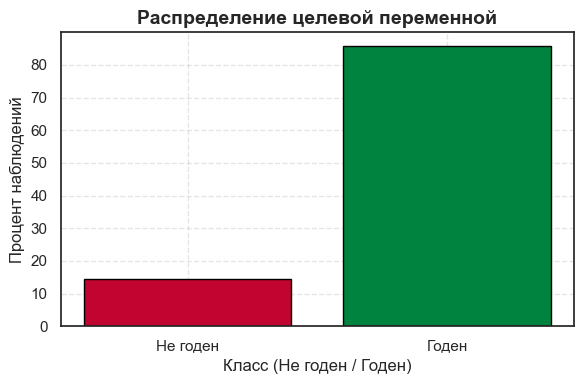

In [140]:
df_plot = pd.DataFrame({'target': dependent, 'hue': dependent})
plt.figure(figsize=(6, 4))

sns.histplot(
    data=df_plot,
    x='target',
    hue='hue',
    bins=2,
    discrete=True,
    stat="percent",
    palette=['#c20430', '#00833f'],
    shrink=0.8,
    alpha=1,
    edgecolor='black'
)

plt.xlabel('Класс (Не годен / Годен)', fontsize=12)
plt.ylabel('Процент наблюдений', fontsize=12)
plt.title('Распределение целевой переменной', fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['Не годен', 'Годен'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

In [170]:
dependent[dependent == 1].sum()

36792

In [172]:
(dependent == 0).sum()

6158

In [182]:
X = independent

singular_values = np.linalg.svd(X, compute_uv=False)
print(f"Сингулярные числа:\n{singular_values}")
print()
rank = np.linalg.matrix_rank(X)
print(f"Ранг матрицы:\n{rank},\nЧисло переменных:\n{X.shape[1]}")

print("Ранг:", np.linalg.matrix_rank(X))
print("Признаков:", X.shape[1])

Сингулярные числа:
[3.26843535e+03 2.07417920e+02 1.63710040e+02 1.30841146e+02
 9.58267803e+01 7.63342919e+01 6.06929748e+01 6.01126338e+01
 5.55987199e+01 5.51009861e+01 5.31245347e+01 5.16439973e+01
 4.98966281e+01 4.81403580e+01 4.54099379e+01 4.12821342e+01
 3.70002922e+01 3.49670383e+01 2.96058653e+01 2.85352392e+01
 2.82415353e+01 2.60627560e+01 2.59224308e+01 2.45090126e+01
 2.34737300e+01 2.24419370e+01 2.00080320e+01 1.94973965e+01
 1.71857904e+01 1.48409679e+01 1.43297663e+01 1.34651828e+01
 1.07945808e+01 2.20486610e+00 9.99520511e-01 2.49734913e-01]

Ранг матрицы:
36,
Число переменных:
36
Ранг: 36
Признаков: 36


In [216]:
X = sm.add_constant(independent)
y = dependent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logit_model = sm.Logit(y_train, X_train)

# Используем оптимизатор BFGS
result = logit_model.fit(method='bfgs', maxiter=1000, disp=True)

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.280232
         Iterations: 255
         Function evaluations: 258
         Gradient evaluations: 258
                           Logit Regression Results                           
Dep. Variable:                 defect   No. Observations:                30065
Model:                          Logit   Df Residuals:                    30029
Method:                           MLE   Df Model:                           35
Date:                Mon, 21 Apr 2025   Pseudo R-squ.:                  0.3188
Time:                        17:46:25   Log-Likelihood:                -8425.2
converged:                       True   LL-Null:                       -12368.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                                                                              coef    std err          z      P>|z|      [0.025  

In [235]:
# Добавляем константу в X_test
X_test_const = sm.add_constant(X_test, has_constant='add')

# Предсказания
y_pred_prob = result.predict(X_test_const)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8665

Confusion Matrix:
[[  522  1320]
 [  400 10643]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38      1842
           1       0.89      0.96      0.93     11043

    accuracy                           0.87     12885
   macro avg       0.73      0.62      0.65     12885
weighted avg       0.84      0.87      0.85     12885



### Проблема с балансировкой классов!

#### 30% наблюдений модель может предсказать идеально на основе одного или нескольких признаков.
#### Проверим признаки - есть ли такие, по которым 100% случаев относятся к одному классу?

In [238]:
for col in independent.columns:
    group_mean = dependent[independent[col] == 1].mean()
    count = (independent[col] == 1).sum()
    
    if group_mean in [0.0, 1.0] and count > 0:
        print(f"Признак '{col}' → все {count} наблюдений имеют target = {group_mean}")

Признак 'diameter_15' → все 904 наблюдений имеют target = 1.0
Признак 'diameter_22' → все 347 наблюдений имеют target = 1.0
Признак 'diameter_25' → все 528 наблюдений имеют target = 1.0
Признак 'diameter_45' → все 542 наблюдений имеют target = 1.0
Признак 'diameter_76' → все 1468 наблюдений имеют target = 1.0
Признак 'steel_grade_10' → все 2427 наблюдений имеют target = 1.0
Признак 'steel_grade_20' → все 191 наблюдений имеют target = 1.0
Признак 'welding_materials_Аргон газообразный высший сорт ГОСТ 10157-2016; Проволока OK Autrod 13.23 классификация ER80S-Ni1по AWS A5.28' → все 717 наблюдений имеют target = 1.0
Признак 'welding_materials_Аргон газообразный высший сорт ГОСТ 10157-2016; Проволока OK Tigrod 13.23(2,4 мм) классификация ER80S-Ni1по AWS A5.28' → все 214 наблюдений имеют target = 1.0
Признак 'welding_materials_Электрод УОНИ 13/55' → все 3635 наблюдений имеют target = 1.0
Признак 'welding_method_ААД' → все 2521 наблюдений имеют target = 1.0


### ИДЕЯ: давайте посмотрим на реализацию из sklearn!
### BaseLine sklearn

In [240]:
# 1. Разделим данные
X = independent
y = dependent

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 2. Инициализация модели
model = LogisticRegression(
    solver='lbfgs',    
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# 3. Обучение модели
model.fit(X_train, y_train)

# 4. Предсказания
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# 5. Оценка
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7774155995343422

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.87      0.53      1842
           1       0.97      0.76      0.85     11043

    accuracy                           0.78     12885
   macro avg       0.67      0.81      0.69     12885
weighted avg       0.89      0.78      0.81     12885


Confusion matrix:
[[1594  248]
 [2620 8423]]


### BaseLine Stratified sklearn

In [246]:
# 1. Разделим данные с сохранением пропорций классов
X = independent
y = dependent

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # stratified split
)

# 2. Инициализация модели
model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# 3. Обучение модели
model.fit(X_train, y_train)

# 4. Предсказания
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# 5. Оценка
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7741559953434226

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.87      0.53      1847
           1       0.97      0.76      0.85     11038

    accuracy                           0.77     12885
   macro avg       0.67      0.81      0.69     12885
weighted avg       0.89      0.77      0.81     12885


Confusion matrix:
[[1610  237]
 [2673 8365]]


#### Стало чуть-чуть лучше!

#### Попытка с Hyperopt

In [269]:
print("\nЗапуск Hyperopt...")
start_time_hyperopt = time.time()

# Пространство поиска
space = {
    'C': hp.loguniform('C', -6, 4),
    'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'saga']),
    'max_iter': hp.quniform('max_iter', 200, 1500, 100)
}

# Скастомленный recall scorer для класса 0
recall_0_scorer = make_scorer(recall_score, pos_label=0)

# Целевая функция
def objective(params):
    model = LogisticRegression(
        C=params['C'],
        solver=params['solver'],
        max_iter=int(params['max_iter']),
        class_weight='balanced',
        penalty='l2',
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=recall_0_scorer, n_jobs=-1).mean()
    hyperopt_pbar.update(1)
    return {'loss': -score, 'status': STATUS_OK, 'params': params}

# Запуск Hyperopt
n_iter_hyperopt = 100
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")
trials = Trials()
best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials,
    verbose=0
)
hyperopt_pbar.close()

# Лучшие параметры и результат
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperopt = trials.trials[best_trial_idx]['result']['params']
best_score_hyperopt = -min([t['result']['loss'] for t in trials.trials])
time_hyperopt = time.time() - start_time_hyperopt

# Финальная модель
final_model = LogisticRegression(
    C=best_params_hyperopt['C'],
    solver=best_params_hyperopt['solver'],
    max_iter=int(best_params_hyperopt['max_iter']),
    class_weight='balanced',
    penalty='l2',
    random_state=42
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Метрики
print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperopt}")
print(f"Лучший CV recall по классу 0: {best_score_hyperopt:.4f}")
print("\nМетрики на тестовых данных:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Запуск Hyperopt...


Hyperopt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [06:08<00:00,  3.68s/it]



Hyperopt завершен за 368.46 секунд
Лучшие параметры: {'C': 11.62033139397693, 'max_iter': 1200.0, 'solver': 'lbfgs'}
Лучший CV recall по классу 0: 0.8587

Метрики на тестовых данных:
Accuracy: 0.7695770275514163

Classification report:
              precision    recall  f1-score   support

           0       0.37      0.87      0.52      1847
           1       0.97      0.75      0.85     11038

    accuracy                           0.77     12885
   macro avg       0.67      0.81      0.68     12885
weighted avg       0.89      0.77      0.80     12885


Confusion matrix:
[[1608  239]
 [2730 8308]]


### Попытка statsmodels и балансировка классов

In [306]:
# 1. Делим данные
X = independent
y = dependent

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Инициализация модели
model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# 3. Обучение модели
model.fit(X_train, y_train)

# 4. Предсказания
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# 5. Оценка качества
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7741559953434226

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.87      0.53      1847
           1       0.97      0.76      0.85     11038

    accuracy                           0.77     12885
   macro avg       0.67      0.81      0.69     12885
weighted avg       0.89      0.77      0.81     12885


Confusion Matrix:
[[1610  237]
 [2673 8365]]


## **CatBoost**
### Только теперь максимизируем f1-score для класса 1 (элемент "годен")

Попробуем теперь другой подход и другой алгоритм. Есть ряд причин, по которым, потенциально, важным может быть именно фактор отсутствия дефекта в рамках стыка.

In [321]:
df_initial_initial = df_initial
df_initial = df_initial[(df_initial["welding_materials"] != "неизвестно")]
df_initial = df_initial.drop(columns=["date", "name", "Unnamed: 0"])

In [325]:
df_catboost = df_initial

In [327]:
df_catboost

,defect,temperature,diameter,steel_grade,welding_method,welding_materials
2,1,27,114,К48,РД,ОК 53.70 Ø3.2
3,1,27,114,К48,РД,ОК 53.70 Ø3.2
4,1,27,108,К48,РД,Электрод УОНИ 13/55
5,1,27,108,К48,РД,Электрод УОНИ 13/55
6,1,27,108,К48,РД,Электрод УОНИ 13/55
...,...,...,...,...,...,...
42938,1,3,426,К48,РД,ОК 53.70 Ø3.2
42940,1,-3,89,09Г2С,РАД,"Аргон газообразный высший сорт ГОСТ 10157-2016; Проволока OK Tigrod 13.23(2,4 мм) классификация ER80S-Ni1по AWS A5.28"
42942,1,1,57,09Г2С,РАД,Аргон газообразный высший сорт ГОСТ 10157-2016; Проволока OK Autrod 13.23 классификация ER80S-Ni1по AWS A5.28
42943,1,1,57,09Г2С,РАД,Аргон газообразный высший сорт ГОСТ 10157-2016; Проволока OK Autrod 13.23 классификация ER80S-Ni1по AWS A5.28


In [335]:
# 1. Выделяем признаки и целевую переменную
categorical_features = ["diameter", "steel_grade", "welding_materials", "welding_method"]
numeric_features = ["temperature"]
model_features = categorical_features + numeric_features
X = df_catboost[model_features]  # ← ключевая правка
y = df_catboost["defect"]

# 2. Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#### CatBoostEncoding

In [337]:
# 1. Выделим категориальные колонки
cat_columns = categorical_features  # ["diameter", "steel_grade", "welding_materials", "welding_method"]

# 2. Инициализация и обучение энкодера на тренировочных данных
target_enc = ce.CatBoostEncoder(cols=cat_columns)
target_enc.fit(X_train[cat_columns], y_train)

# 3. Трансформация и присоединение к train/test
X_train_cb = X_train.join(target_enc.transform(X_train[cat_columns]).add_suffix('_cb'))
X_test_cb = X_test.join(target_enc.transform(X_test[cat_columns]).add_suffix('_cb'))

In [339]:
categorical_features = ["diameter_cb", "steel_grade_cb", "welding_materials_cb", "welding_method_cb"]
numeric_features = ["temperature"]
model_features = categorical_features + numeric_features

In [377]:
# 1. Обучение модели на закодированных признаках
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='F1',
    early_stopping_rounds=50,
    verbose=100,
    random_state=42
)

model.fit(
    X_train_cb[model_features], y_train,
    eval_set=(X_test_cb[model_features], y_test),
    use_best_model=True
)


# 3. Метрики
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

0:	learn: 0.8859319	test: 0.8884701	best: 0.8884701 (0)	total: 7.9ms	remaining: 7.89s
100:	learn: 0.9392558	test: 0.9405443	best: 0.9405443 (81)	total: 2.48s	remaining: 22.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9427328111
bestIteration = 123

Shrink model to first 124 iterations.

Accuracy: 0.9094934957099363

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       798
           1       0.93      0.96      0.94      2815

    accuracy                           0.91      3613
   macro avg       0.88      0.84      0.86      3613
weighted avg       0.91      0.91      0.91      3613


Confusion Matrix:
[[ 582  216]
 [ 111 2704]]


### Затюненный CatBoost

In [380]:
print("\nЗапуск Hyperopt...")
start_time_hyperopt = time.time()

# Поиск по параметрам
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'depth': hp.quniform('depth', 1, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'border_count': hp.quniform('border_count', 32, 255, 1)
}

# Функция для подбора порога по максимальному f1
def find_best_threshold(y_true, y_probs):
    best_threshold = 0.5
    best_f1 = 0
    for t in np.arange(0.01, 1.00, 0.01):
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_true, y_pred)
        if score > best_f1:
            best_f1 = score
            best_threshold = t
    return best_threshold, best_f1

# Objective для Hyperopt
def objective(params):
    params = {k: int(v) if 'count' in k or k == 'depth' else v for k, v in params.items()}
    
    # Внутреннее разделение на train/val внутри objective
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_cb[model_features], y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    model = CatBoostClassifier(
        iterations=1000,
        early_stopping_rounds=50,
        eval_metric='F1',
        verbose=0,
        random_state=42,
        **params
    )
    
    model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), use_best_model=True)
    y_proba_val = model.predict_proba(X_val_split)[:, 1]

    # Подбор трешхолда
    best_threshold, best_f1 = find_best_threshold(y_val_split, y_proba_val)

    hyperopt_pbar.update(1)
    return {'loss': -best_f1, 'status': STATUS_OK, 'params': params}

# Запуск Hyperopt
n_iter_hyperopt = 30
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")
trials = Trials()

best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials,
    verbose=0
)
hyperopt_pbar.close()

# Лучшие параметры
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperopt = trials.trials[best_trial_idx]['result']['params']
best_score_hyperopt = -min([t['result']['loss'] for t in trials.trials])
time_hyperopt = time.time() - start_time_hyperopt

# Обучение на всех train-данных + подбор трешхолда
final_model = CatBoostClassifier(
    iterations=1000,
    early_stopping_rounds=50,
    eval_metric='F1',
    verbose=100,
    random_state=42,
    **best_params_hyperopt
)
final_model.fit(
    X_train_cb[model_features], y_train,
    eval_set=(X_test_cb[model_features], y_test),
    use_best_model=True
)
y_proba_test = final_model.predict_proba(X_test_cb[model_features])[:, 1]
final_threshold, final_f1 = find_best_threshold(y_test, y_proba_test)
y_pred_final = (y_proba_test >= final_threshold).astype(int)

# Метрики
print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperopt}")
print(f"Лучший f1 на валидации (подбор трешхолда): {best_score_hyperopt:.4f}")
print(f"Оптимальный threshold на тесте: {final_threshold:.2f} (F1: {final_f1:.4f})")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))


Запуск Hyperopt...


Hyperopt: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.01s/it]


0:	learn: 0.8989550	test: 0.8988989	best: 0.8988989 (0)	total: 38.3ms	remaining: 38.3s
100:	learn: 0.9413048	test: 0.9428173	best: 0.9430667 (52)	total: 2.22s	remaining: 19.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9430667132
bestIteration = 52

Shrink model to first 53 iterations.

Hyperopt завершен за 120.19 секунд
Лучшие параметры: {'border_count': 62, 'depth': 7, 'l2_leaf_reg': 1.3727298821854577, 'learning_rate': 0.1910140410275537}
Лучший f1 на валидации (подбор трешхолда): 0.9439
Оптимальный threshold на тесте: 0.59 (F1: 0.9432)

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       798
           1       0.96      0.93      0.94      2815

    accuracy                           0.91      3613
   macro avg       0.87      0.89      0.88      3613
weighted avg       0.92      0.91      0.91      3613


Confusion Matrix:
[[ 675  123]
 [ 193 2622]]


#### Лучшие параметры: {'border_count': 62, 'depth': 7, 'l2_leaf_reg': 1.3727298821854577, 'learning_rate': 0.1910140410275537}

### Теперь попробую на 100 итерациях

In [383]:
print("\nЗапуск Hyperopt...")
start_time_hyperopt = time.time()

# Поиск по параметрам
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'depth': hp.quniform('depth', 1, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'border_count': hp.quniform('border_count', 32, 255, 1)
}

# Функция для подбора порога по максимальному f1
def find_best_threshold(y_true, y_probs):
    best_threshold = 0.5
    best_f1 = 0
    for t in np.arange(0.01, 1.00, 0.01):
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_true, y_pred)
        if score > best_f1:
            best_f1 = score
            best_threshold = t
    return best_threshold, best_f1

# Objective для Hyperopt
def objective(params):
    params = {k: int(v) if 'count' in k or k == 'depth' else v for k, v in params.items()}
    
    # Внутреннее разделение на train/val внутри objective
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_cb[model_features], y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    model = CatBoostClassifier(
        iterations=1000,
        early_stopping_rounds=50,
        eval_metric='F1',
        verbose=0,
        random_state=42,
        **params
    )
    
    model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), use_best_model=True)
    y_proba_val = model.predict_proba(X_val_split)[:, 1]

    # Подбор трешхолда
    best_threshold, best_f1 = find_best_threshold(y_val_split, y_proba_val)

    hyperopt_pbar.update(1)
    return {'loss': -best_f1, 'status': STATUS_OK, 'params': params}

# Запуск Hyperopt
n_iter_hyperopt = 100
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")
trials = Trials()

best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials,
    verbose=0
)
hyperopt_pbar.close()

# Лучшие параметры
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperopt = trials.trials[best_trial_idx]['result']['params']
best_score_hyperopt = -min([t['result']['loss'] for t in trials.trials])
time_hyperopt = time.time() - start_time_hyperopt

# Обучение на всех train-данных + подбор трешхолда
final_model = CatBoostClassifier(
    iterations=1000,
    early_stopping_rounds=50,
    eval_metric='F1',
    verbose=100,
    random_state=42,
    **best_params_hyperopt
)
final_model.fit(
    X_train_cb[model_features], y_train,
    eval_set=(X_test_cb[model_features], y_test),
    use_best_model=True
)
y_proba_test = final_model.predict_proba(X_test_cb[model_features])[:, 1]
final_threshold, final_f1 = find_best_threshold(y_test, y_proba_test)
y_pred_final = (y_proba_test >= final_threshold).astype(int)

# Метрики
print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperopt}")
print(f"Лучший f1 на валидации (подбор трешхолда): {best_score_hyperopt:.4f}")
print(f"Оптимальный threshold на тесте: {final_threshold:.2f} (F1: {final_f1:.4f})")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))


Запуск Hyperopt...


Hyperopt: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [07:29<00:00,  4.49s/it]


0:	learn: 0.8990299	test: 0.8988989	best: 0.8988989 (0)	total: 39.1ms	remaining: 39.1s
100:	learn: 0.9413048	test: 0.9428173	best: 0.9428173 (65)	total: 2.87s	remaining: 25.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9429816914
bestIteration = 109

Shrink model to first 110 iterations.

Hyperopt завершен за 449.16 секунд
Лучшие параметры: {'border_count': 169, 'depth': 8, 'l2_leaf_reg': 2.173966957837414, 'learning_rate': 0.19142208031104677}
Лучший f1 на валидации (подбор трешхолда): 0.9443
Оптимальный threshold на тесте: 0.39 (F1: 0.9432)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       798
           1       0.90      0.99      0.94      2815

    accuracy                           0.91      3613
   macro avg       0.93      0.80      0.84      3613
weighted avg       0.91      0.91      0.90      3613


Confusion Matrix:
[[ 485  313]
 [  23 2792]]


#### Лучшие параметры: {'border_count': 169, 'depth': 8, 'l2_leaf_reg': 2.173966957837414, 'learning_rate': 0.19142208031104677}

### Теперь попробую на 500 итерациях

In [388]:
print("\nЗапуск Hyperopt...")
start_time_hyperopt = time.time()

# Поиск по параметрам
space = {
    'learning_rate': hp.uniform('learning_rate', 0.18, 0.2),
    'depth': hp.quniform('depth', 7, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 3),
    'border_count': hp.quniform('border_count', 32, 255, 1)
}

# Функция для подбора порога по максимальному f1
def find_best_threshold(y_true, y_probs):
    best_threshold = 0.5
    best_f1 = 0
    for t in np.arange(0.01, 1.00, 0.01):
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_true, y_pred)
        if score > best_f1:
            best_f1 = score
            best_threshold = t
    return best_threshold, best_f1

# Objective для Hyperopt
def objective(params):
    params = {k: int(v) if 'count' in k or k == 'depth' else v for k, v in params.items()}
    
    # Внутреннее разделение на train/val внутри objective
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_cb[model_features], y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    model = CatBoostClassifier(
        iterations=1000,
        early_stopping_rounds=50,
        eval_metric='F1',
        verbose=0,
        random_state=42,
        **params
    )
    
    model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), use_best_model=True)
    y_proba_val = model.predict_proba(X_val_split)[:, 1]

    # Подбор трешхолда
    best_threshold, best_f1 = find_best_threshold(y_val_split, y_proba_val)

    hyperopt_pbar.update(1)
    return {'loss': -best_f1, 'status': STATUS_OK, 'params': params}

# Запуск Hyperopt
n_iter_hyperopt = 500
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")
trials = Trials()

best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials,
    verbose=0
)
hyperopt_pbar.close()

# Лучшие параметры
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperopt = trials.trials[best_trial_idx]['result']['params']
best_score_hyperopt = -min([t['result']['loss'] for t in trials.trials])
time_hyperopt = time.time() - start_time_hyperopt

# Обучение на всех train-данных + подбор трешхолда
final_model = CatBoostClassifier(
    iterations=1000,
    early_stopping_rounds=50,
    eval_metric='F1',
    verbose=100,
    random_state=42,
    **best_params_hyperopt
)
final_model.fit(
    X_train_cb[model_features], y_train,
    eval_set=(X_test_cb[model_features], y_test),
    use_best_model=True
)
y_proba_test = final_model.predict_proba(X_test_cb[model_features])[:, 1]
final_threshold, final_f1 = find_best_threshold(y_test, y_proba_test)
y_pred_final = (y_proba_test >= final_threshold).astype(int)

# Метрики
print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperopt}")
print(f"Лучший f1 на валидации (подбор трешхолда): {best_score_hyperopt:.4f}")
print(f"Оптимальный threshold на тесте: {final_threshold:.2f} (F1: {final_f1:.4f})")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))


Запуск Hyperopt...



Hyperopt:   9%|██████▍                                                                | 27/300 [03:46<38:13,  8.40s/it]

Hyperopt: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [40:37<00:00,  4.88s/it]


0:	learn: 0.8990299	test: 0.8988989	best: 0.8988989 (0)	total: 41.9ms	remaining: 41.8s
100:	learn: 0.9413614	test: 0.9427774	best: 0.9427774 (99)	total: 2.83s	remaining: 25.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9427773901
bestIteration = 99

Shrink model to first 100 iterations.

Hyperopt завершен за 2437.69 секунд
Лучшие параметры: {'border_count': 179, 'depth': 8, 'l2_leaf_reg': 1.0781525484594054, 'learning_rate': 0.19560189021696545}
Лучший f1 на валидации (подбор трешхолда): 0.9444
Оптимальный threshold на тесте: 0.26 (F1: 0.9430)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       798
           1       0.90      0.99      0.94      2815

    accuracy                           0.91      3613
   macro avg       0.93      0.80      0.84      3613
weighted avg       0.91      0.91      0.90      3613


Confusion Matrix:
[[ 481  317]
 [  21 2794]]


### Выводы:

- Рассмотрели ряд реализаций логистической регрессии;
- Опробовали CatBoost для максимизации f1-score - оценка релевантности подхода на будущие исследования.